# Low-Rank Matrix Completion

# Milad Jalali, Alireza Naderi

# Introduction

# Basics

In [1]:
import argparse
import os
import pickle
import pandas as pd

%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from numpy.linalg import solve

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

np.random.seed(1337)

def error_plot(ys, yscale='log'):
    plt.figure(figsize=(8, 8))
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.yscale(yscale)
    plt.plot(range(len(ys)), ys)

# Projection onto the nuclear norm ball

In [2]:
def simplex_projection(a):
    #check if the point is already in the simplex
    if np.sum(a) <=1 and np.alltrue(a >= 0):
        return a
    # sort the array in decreasing order then compute cumulative sum of array elements
    s = np.sort(a)[::-1]
    cumsum_u = np.cumsum(s)
    # rho is the number of nonzero elements of the solution
    rho = np.nonzero(s * np.arange(1, len(s)+1) > (cumsum_u - 1))[0][-1]
    # theta is the lagrangian multiplier
    theta = (cumsum_u[rho] - 1) / (rho + 1.0)
    # thresholding
    return np.maximum(a-theta, 0)

In [3]:
def nuclear_projection(A):
    U, sigma, V = np.linalg.svd(A, full_matrices=False)
    projected_sigma = simplex_projection(sigma)
    return U.dot(np.diag(projected_sigma).dot(V))

# Objective Function & Gradient

In [4]:
def my_function(M, O, X):
    return 0.5 * np.linalg.norm(M-np.multiply(X, O), 'fro')**2

In [5]:
def my_function_gradient(M, O, X):
    return np.multiply(X, O) - M

In [22]:
m = 5000
n = 5000
k = 10
# we will produce a (m,n) matrix of rank k named A
U = np.random.normal(0, 1, (m, k))
U = np.linalg.qr(U)[0]
V = np.random.normal(0, 1, (n, k))
V = np.linalg.qr(V)[0]
S = np.diag(np.random.uniform(0, 1, k))
S /= np.sum(S)
A = U.dot(S.dot(V.T))
# O represents the observed enteries 
O = np.random.randint(0,2, (m, n))
M = np.multiply(A, O)

In [23]:
X0 = np.random.normal(0,1, (m,n))
X0 = nuclear_projection(X0)
print(my_function(M, O, X0))
print(my_function_gradient(M, O, X0))

0.18797893278690808
[[ 0.00000000e+00 -6.81480831e-05  0.00000000e+00 ...  1.89965078e-04
   0.00000000e+00 -4.22359324e-05]
 [ 2.35471888e-04  2.79979960e-05 -0.00000000e+00 ...  1.80946248e-04
   1.54742442e-04 -1.52468941e-04]
 [ 2.10242468e-04  0.00000000e+00 -6.63190703e-05 ...  0.00000000e+00
   0.00000000e+00 -1.78623557e-04]
 ...
 [ 2.09791617e-04  0.00000000e+00 -0.00000000e+00 ...  0.00000000e+00
   7.53720431e-06  0.00000000e+00]
 [-3.35825119e-05  5.29527177e-05 -6.14642781e-05 ...  5.56964095e-05
   0.00000000e+00 -2.86035448e-05]
 [ 0.00000000e+00 -5.10171060e-05  0.00000000e+00 ...  4.52021733e-06
   0.00000000e+00  0.00000000e+00]]


# Power Method

In [8]:
def power_method(A, num_steps=10):
    m, n = A.shape
    x = np.random.normal(0, 1, m).reshape(-1,1)
    x /= np.linalg.norm(x)
    y = A.T.dot(x)
    y /= np.linalg.norm(y)
    for _ in range(num_steps):
        x = A.dot(y)
        x /= np.linalg.norm(x)
        y = A.T.dot(x)
        y /= np.linalg.norm(y)
    return x, y

# Oracle Computation

In [9]:
def my_oracle(M, O, X):
    G = my_function_gradient(M, O, X)
    x, y = power_method(-G)
    return x.dot(y.T)

In [24]:
my_oracle(M, O, X0)

array([[-1.99171681e-04, -3.33765615e-05,  4.63875677e-05, ...,
        -1.22885043e-04, -1.47226394e-04,  5.73567443e-05],
       [-3.96576867e-04, -6.64570995e-05,  9.23637146e-05, ...,
        -2.44680194e-04, -2.93147007e-04,  1.14204780e-04],
       [-4.34693937e-04, -7.28446377e-05,  1.01241273e-04, ...,
        -2.68197683e-04, -3.21322894e-04,  1.25181597e-04],
       ...,
       [-3.18629994e-04, -5.33950084e-05,  7.42096986e-05, ...,
        -1.96588493e-04, -2.35529191e-04,  9.17579196e-05],
       [ 1.24976695e-05,  2.09432000e-06, -2.91073754e-06, ...,
         7.71081837e-06,  9.23819491e-06, -3.59903391e-06],
       [ 5.49569730e-05,  9.20951603e-06, -1.27996123e-05, ...,
         3.39073807e-05,  4.06238322e-05, -1.58263114e-05]])

# Frank Wolfe

In [11]:
def frank_wolfe(init, steps, oracle):
    xs = [init]
    
    for step in steps:
        xs.append(xs[-1] + step*(oracle(xs[-1])-xs[-1]))        
    return xs

In [25]:
import time
start_time = time.time()
oracle = lambda X: my_oracle(M, O, X)
steps = [2./(k+2.) for k in range(1, 40)]
Xs = frank_wolfe(X0, steps, oracle)
end_time = time.time()
fo_runtime = end_time - start_time

In [26]:
fo_runtimentime

63.79366493225098

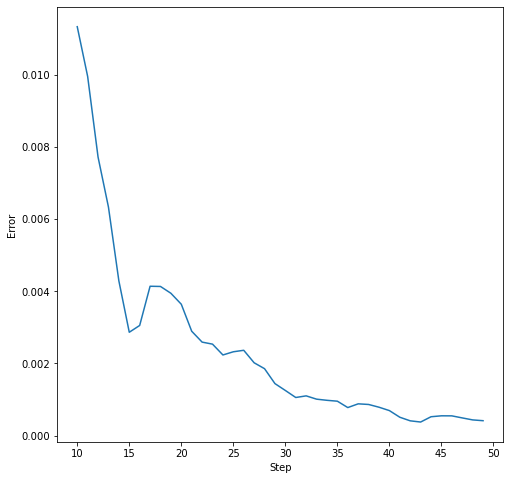

In [20]:
function = lambda X: my_function(M, O, X)
objective = [function(X) for X in Xs]
domain = [np.linalg.norm(X-M, 'fro')**2 for X in Xs]

plt.figure(figsize=(8, 8))
plt.xlabel('Step')
plt.ylabel('Error')
# plt.yscale('log')
plt.plot(range(10,len(objective)), objective[10:])

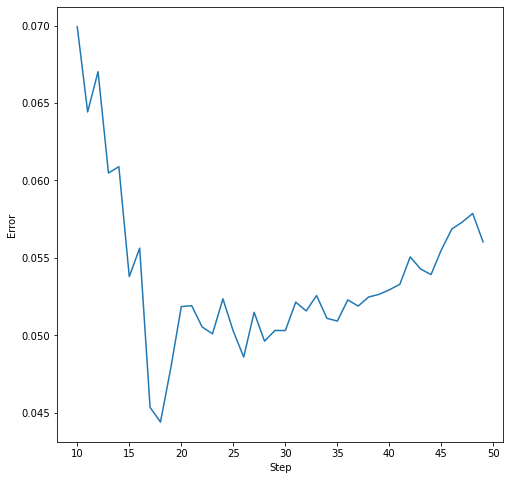

In [21]:
plt.figure(figsize=(8, 8))
plt.xlabel('Step')
plt.ylabel('Error')
plt.plot(range(10,len(domain)), domain[10:])